In [102]:
# LSTM Autoencoder를 이용한 이상 온도 탐지
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from myProcessData import myProcessData

# 데이터 준비
# temperature.csv 파일에서 데이터 불러오기
all_data = []
data = pd.read_csv('csv/pjh_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/pjh_temperature2.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/jdk_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/bsb_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

# # 데이터 전처리 -----------------------------------------------
sequence_length = 20 # 시퀀스 길이 설정
train_dataset, train_dataloader, test_subset_dataset = myProcessData(all_data[0], sequence_length)

481


In [103]:
# 모델 구성
class CAE(nn.Module):
    def __init__(self, sequence_length):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LSTM(16, 1, 2, batch_first=True),
        )
        self.LSTM_encoder = nn.LSTM(16, 8, 2, batch_first=True)
        self.LSTM_decoder = nn.LSTM(8, 16, 2, batch_first=True)
        self.sequence_length = sequence_length

    def forward(self, x):
        encoded_output = self.encoder(x)
        encoded_output = encoded_output.reshape(-1, int(self.sequence_length/2/2), 16)
        _, (hidden, _) = self.LSTM_encoder(encoded_output)
        decoded_output, _ = self.LSTM_decoder(hidden)
        decoded_output = decoded_output.reshape(-1, 16, 32)
        decoded_output = self.decoder(decoded_output)
        return decoded_output
    

# 모델 생성
model = CAE(sequence_length)
# print(model)

learning_rate = 0.001
num_epochs = 100  # 학습 횟수 설정
batch_size = 32

loss_function = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer


In [104]:

# K-fold Cross Validation
k = 4  # Number of folds
fold_losses = []
test_losses = []  # List to store the test losses
result_fold_loss = []
# K-fold data splitting
for i in range(k):
    print(f"Fold {i+1}")
    
    train_dataset, train_dataloader, test_subset_dataset = myProcessData(all_data[i], sequence_length)
    train_dataset = train_dataset.reshape(-1, 1, sequence_length)
    train_subset_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 모델 초기화
    model = CAE(sequence_length)
    
    # 학습
    fold_loss=[]
    for epoch in range(num_epochs):
        print(f"epochs: {epoch}")
        for data in train_subset_dataloader:
            target = data
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_function(outputs, data)
            loss.backward()
            optimizer.step()
        fold_loss.append(loss.item())

    # 테스트 데이터에 대한 재구성 오차 계산
    with torch.no_grad():
        test_subset_dataset = test_subset_dataset.reshape(-1, 1, sequence_length)
        test_subset_outputs = model(test_subset_dataset)
        test_subset_loss = loss_function(test_subset_outputs, test_subset_dataset)


    # Append the average test loss to test_losses list
    print(f"Loss after training: {fold_loss[-1]}")
    print(f"Fold {i+1} Test loss: {test_subset_loss.item()}")
    print('===========================================================')
    # 수정. 학습결과인 MSE를 기록한다.
    fold_losses.append(fold_loss)
    # 각 fold 별 최종 학습 결과인 MSE를 기록
    result_fold_loss.append(fold_loss[-1])

    # 이건 미리 나눴던 테스트 데이터들을 이용해 예측한 결과인 MSE
    test_losses.append(test_subset_loss.item())

Fold 1
481
epochs: 0


RuntimeError: Given transposed=1, weight of size [128, 32, 2], expected input[2, 16, 32] to have 128 channels, but got 16 channels instead

Training result: [0.9874418377876282, 0.7411105036735535, 0.7279232740402222, 0.7923194766044617]
Each test result: [0.23776192963123322, 1.3376257419586182, 1.265982747077942, 1.4540632963180542]
Mean threshold: 0.2378


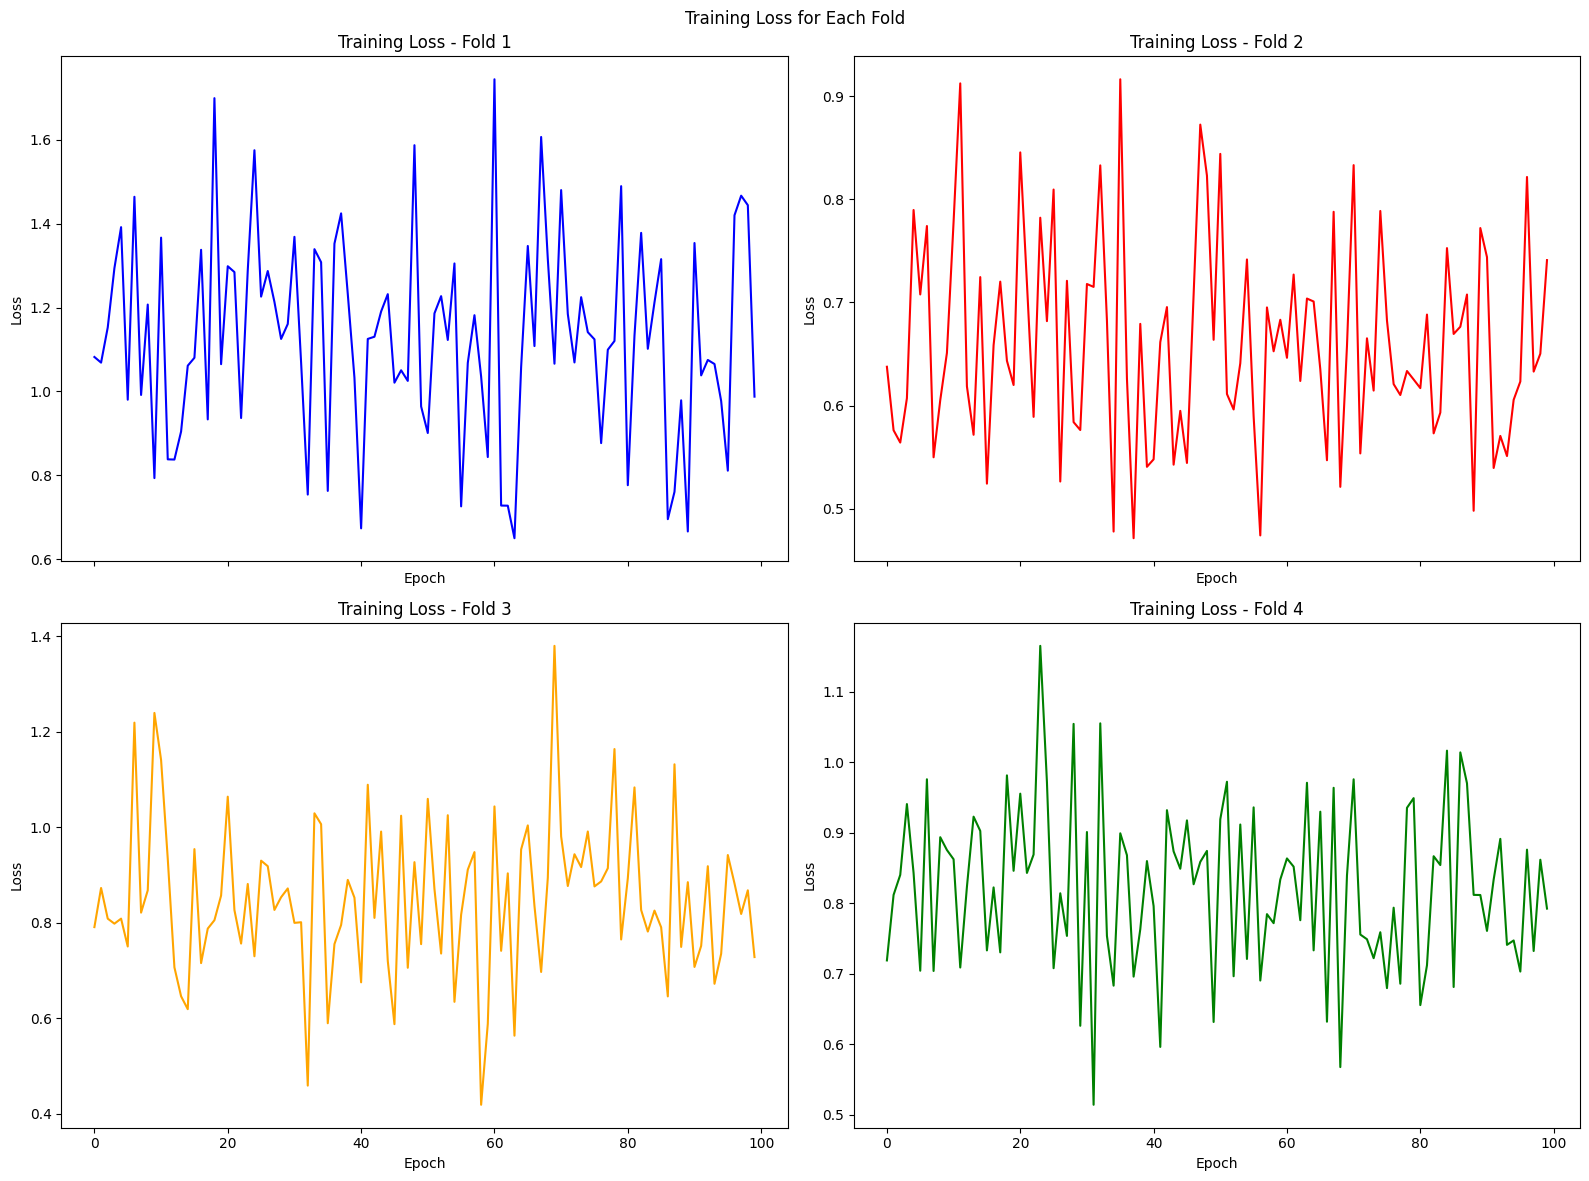

In [ ]:
# 최소값과 인접한 값을 클러스터링
# K-means 알고리즘 적용
print(f"Training result: {result_fold_loss}")
print(f"Each test result: {test_losses}")
data = np.array(test_losses).reshape(-1, 1)
k = 2  # 클러스터 개수
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(data)

# 클러스터링 결과 확인
labels = kmeans.labels_
min_value = np.min(test_losses)
min_label = labels[data.flatten() == min_value]
cluster_data = data[labels == min_label]
# Calculate the mean threshold
mean_threshold = np.mean(cluster_data)
print(f"Mean threshold: {mean_threshold:.4f}")



# 테스트 데이터에 대한 이상 감지
# anomaly_indices = torch.where(test_subset_loss > mean_threshold)[0]
# anomaly_data = test_data[anomaly_indices]
# # 이상 감지 결과 출력
# print(f'Anomaly data indices: {anomaly_indices.tolist()}')
# anomaly_data = (anomaly_data * std) + mean
# print(f"Anomaly data: {anomaly_data}")


# Plotting the losses for each fold
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

axes[0, 0].plot(range(len(fold_losses[0])), fold_losses[0], 'b', label="Fold 1")
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss - Fold 1')

axes[0, 1].plot(range(len(fold_losses[1])), fold_losses[1], 'r', label="Fold 2")
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training Loss - Fold 2')

axes[1, 0].plot(range(len(fold_losses[2])), fold_losses[2], 'orange', label="Fold 3")
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss - Fold 3')

axes[1, 1].plot(range(len(fold_losses[3])), fold_losses[3], 'g', label="Fold 4")
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training Loss - Fold 4')


plt.suptitle('Training Loss for Each Fold')
plt.tight_layout()
plt.show()

# # 테스트 데이터 - 손실값 
# print(test_data)
# print(test_losses)
# plt.figure(figsize=(10, 6))
# # for i, test_loss in enumerate(test_losses):
# #     plt.plot(range(len(test_loss)), test_loss, label="Test")
# plt.bar(range(len(test_losses)), test_losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.grid(True)
# plt.show()

In [ ]:
# 비정상 데이터 생성 =======================================
# 데이터 파일 불러오기
data = pd.read_csv('csv/bsb_temperature.csv')
abnormal_data = data['temperature'].values
abnormal_data = abnormal_data[:500]

# Noise case 1 : 정현파 노이즈
X=np.linspace(0,4*np.pi,len(abnormal_data))
sin_wave=np.sin(X)
abnormal_data += sin_wave

# Noise case 2 : 특정 구간 랜덤 노이즈
start_index = 200
end_index = 400
interval_length = end_index - start_index
noise = np.random.normal(0, 0.5, interval_length)
abnormal_data[start_index:end_index] += noise

# Normalization
abnormal_mean = np.mean(abnormal_data)
abnormal_std = np.std(abnormal_data)
abnormal_data = (abnormal_data - abnormal_mean) / abnormal_std

# 데이터를 시계열 시퀀스로 변환
abnormal_sequence = []
for i in range(len(abnormal_data) - sequence_length + 1):
    sequence = abnormal_data[i:i+sequence_length]
    abnormal_sequence.append(sequence)
# PyTorch 데이터셋 생성
abnormal_dataset = torch.Tensor(abnormal_sequence)
# 2D로 변환
abnormal_dataset = np.reshape(abnormal_dataset, (-1, sequence_length, input_size))



# 비정상 데이터에 대한 재구성 오차 계산
with torch.no_grad():
    abnormal_outputs = model(abnormal_dataset)
    abnormal_loss = loss_function(abnormal_outputs, abnormal_dataset)
print(f'Abnormal data loss: {abnormal_loss.item():.4f}')

# ===============================================

NameError: name 'input_size' is not defined